In [8]:
from nuscenes import NuScenes, NuScenesExplorer
root = '/mnt/d/datasets/nuscenes'
nusc = NuScenes(version='v1.0-mini', dataroot=root, verbose=True)
nusc_exp = NuScenesExplorer(nusc)
my_sample = nusc.sample[0]
# nusc.render_pointcloud_in_image(my_sample['token'], pointsensor_channel='LIDAR_TOP')

points, coloring, im = nusc_exp.map_pointcloud_to_image(
    pointsensor_token=my_sample['data']['LIDAR_TOP'],
    camera_token=my_sample['data']['CAM_FRONT'],
    min_dist=1.0,
    render_intensity=False,
    show_lidarseg=False,
    filter_lidarseg_labels=None,
    lidarseg_preds_bin_path=None,
    show_panoptic=False
)
points = points[0:2, :]

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 3.711 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


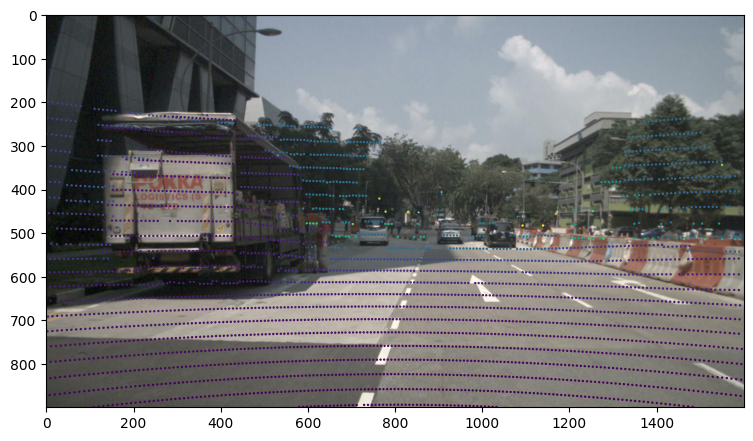

In [3]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(im)
ax.scatter(points[0, :], points[1, :], c=coloring, s=0.5)

In [4]:
def map_pcs2img(sample, nusc_exp):
    points, coloring, im = nusc_exp.map_pointcloud_to_image(
        pointsensor_token=sample['data']['LIDAR_TOP'],
        camera_token=sample['data']['CAM_FRONT'],
        min_dist=1.0,
        render_intensity=False,
        show_lidarseg=False,
        filter_lidarseg_labels=None,
        lidarseg_preds_bin_path=None,
        show_panoptic=False
    )
    points = points[0:2, :]
    return points, coloring, im

In [5]:
import torch

def load_midas(model_type):
    midas = torch.hub.load("intel-isl/MiDaS", model_type)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform

    return midas, transform, device

In [6]:
import cv2

def compute_depth(midas, transform, device, filename):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    return prediction

In [7]:
def plot_depths(mde_depths, lidar_pcs, coloring):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(mde_depths, cmap='inferno')
    ax.scatter(lidar_pcs[0, :], lidar_pcs[1, :], c=coloring, s=0.8, cmap='viridis')
    ax.axis('off')
    plt.show()

In [9]:
import torch
from tqdm import tqdm
import numpy as np

nusc = NuScenes(version='v1.0-mini', dataroot=root, verbose=False)
nusc_exp = NuScenesExplorer(nusc)
midas, transform, device = load_midas("DPT_Large")
samples = nusc.sample
lidar_pcs = []
mde_depths = []
colorings = []

for sample in tqdm(samples):
    points, coloring, im = map_pcs2img(sample, nusc_exp)
    im_path = nusc.get('sample_data', sample['data']['CAM_FRONT'])['filename']
    full_im_path = root + '/' + im_path
    lidar_pcs.append(points)
    mde_dpt = compute_depth(midas, transform, device, full_im_path)
    mde_dpt = mde_dpt.cpu().numpy()
    mde_depths.append(mde_dpt)
    colorings.append(coloring)


Using cache found in /home/alberto/.cache/torch/hub/intel-isl_MiDaS_master
/home/alberto/envs_python/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using cache found in /home/alberto/.cache/torch/hub/intel-isl_MiDaS_master
  1%|          | 5/404 [02:24<3:12:00, 28.87s/it]


In [ ]:
plot_depths(mde_depths[0], lidar_pcs[0], colorings[0])

In [ ]:
def plot_compare_depths(fig, ax, lidar_depths, mde_depths, coloring):
    xpcs = lidar_depths[0, :]
    ypcs = lidar_depths[1, :]
    x = []
    y = []
    z_est = []
    z_gt = []
    for px, py, pz in zip(xpcs, ypcs, coloring):
        px, py = int(px), int(py)
        if px >= mde_depths.shape[0] or py >= mde_depths.shape[1]:
            continue
        mde = mde_depths[px, py]
        x.append(px)
        y.append(py)
        z_est.append(mde)
        z_gt.append(pz)
    ax.plot(z_gt, z_est, 'o', markersize=1, color = 'navy')
    ax.set_xlabel('Ground Truth Depth [m]')
    ax.set_ylabel('Estimated Depth')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
samples = nusc.sample
for i in range(len(samples)):
    plot_compare_depths(fig, ax, lidar_pcs[i], mde_depths[i], colorings[i])

In [ ]:
def hm_depths(fig, ax, lidar_depths, mde_depths, coloring):
    xpcs = lidar_depths[0, :]
    ypcs = lidar_depths[1, :]
    x = []
    y = []
    z_est = []
    z_gt = []
    for px, py, pz in zip(xpcs, ypcs, coloring):
        px, py = int(px), int(py)
        if px >= mde_depths.shape[0] or py >= mde_depths.shape[1]:
            continue
        mde = mde_depths[px, py]
        x.append(px)
        y.append(py)
        z_est.append(mde)
        z_gt.append(pz)

    ax.hist2d(z_gt, z_est, bins=100, cmap='inferno')
    ax.set_xlabel('Ground Truth Depth [m]')
    ax.set_ylabel('Estimated Depth')

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
samples = nusc.sample
for i in range(len(samples)):
    hm_depths(fig, ax, lidar_pcs[i], mde_depths[i], colorings[i])